# Lesson 8.04 Time Series II

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from prophet import Prophet

## Data Processing

In [2]:
# read csv file
# More info on data set can be found at https://data.gov.sg/dataset/container-throughput-monthly-total
df = pd.read_csv('container-throughput-monthly.csv', index_col='date', parse_dates=True)
df.head()

,container_throughput
date,
1995-01-28,946.36
1995-02-28,867.45
1995-03-28,969.54
1995-04-28,960.13
1995-05-28,988.27


In [3]:
# Resets any prevailing indexes of the DataFrame, and use the default one instead
df = df.reset_index()

In [4]:
# Requirement for FBProphet Model - Date column to be named as ds and Y column to be named as y
df=df.rename(columns={'date':'ds', 'container_throughput':'y'})

In [5]:
# optional check
df.head()

,ds,y
0,1995-01-28,946.36
1,1995-02-28,867.45
2,1995-03-28,969.54
3,1995-04-28,960.13
4,1995-05-28,988.27


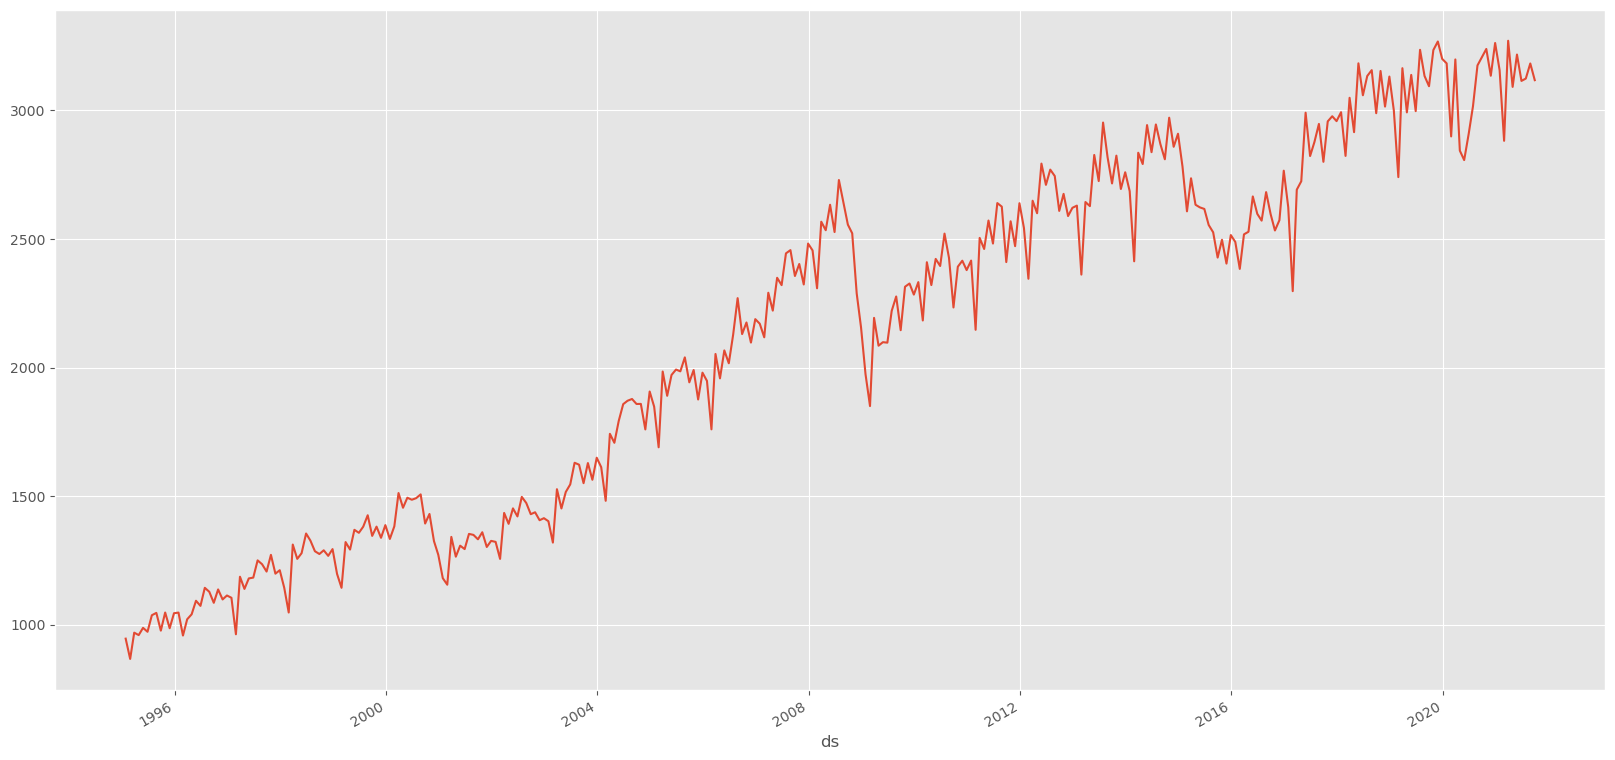

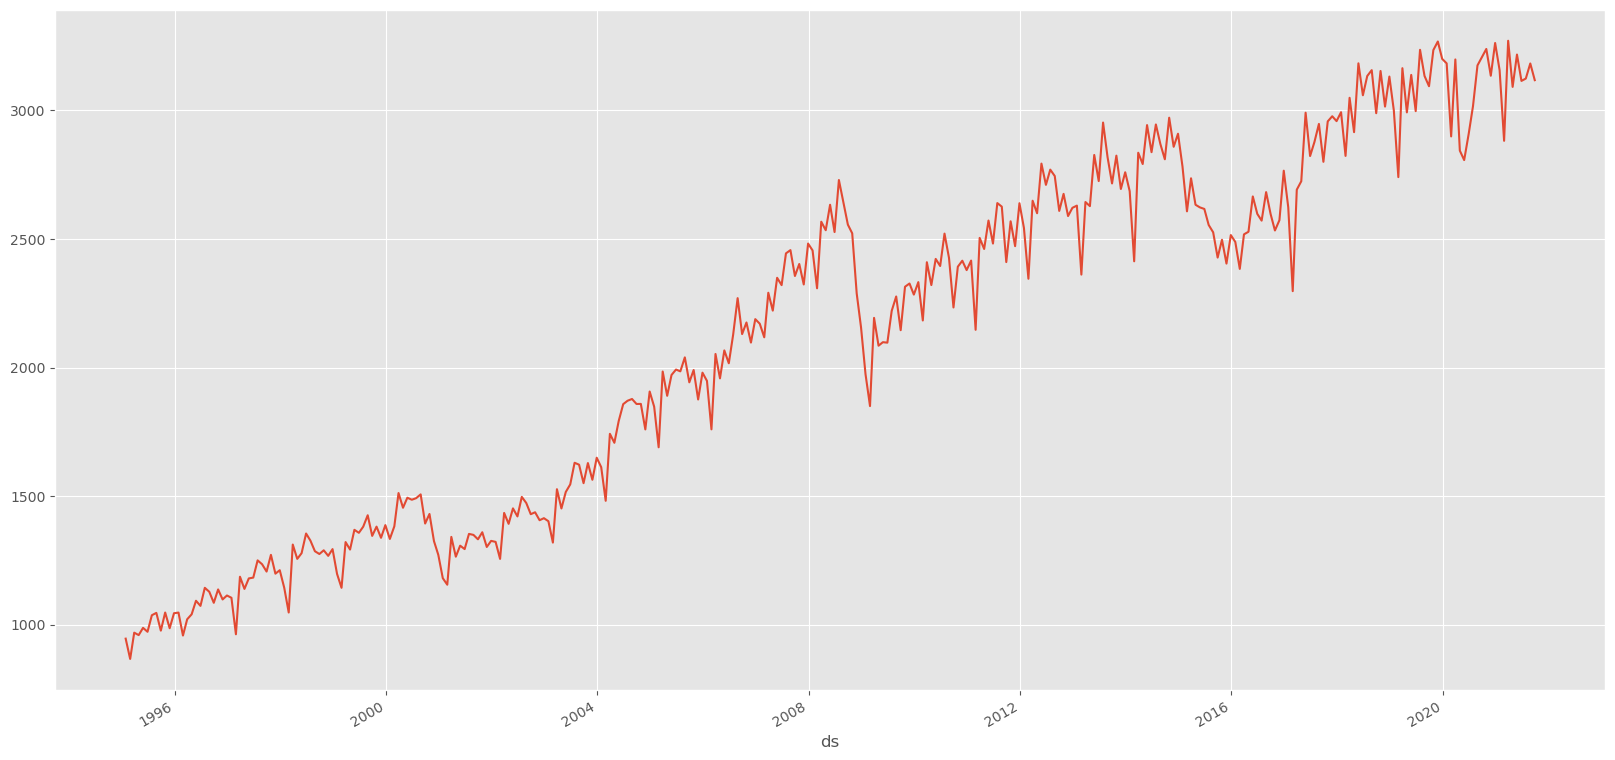

In [6]:
# Plot the data set
df.set_index('ds').y.plot().get_figure()

In [7]:
# Monthly seasonality will be set to True by default since FBProphet would have inferred it from the data set
model = Prophet(seasonality_mode='additive', weekly_seasonality=False)

# Train the model
model.fit(df);

# optional print - to check the status of weekly seasonality
model.seasonality_mode

23:45:12 - cmdstanpy - INFO - Chain [1] start processing
23:45:12 - cmdstanpy - INFO - Chain [1] done processing


'additive'

In [8]:
# Use help(Prophet) for more details about the options available for each method 
# Read more at https://facebook.github.io/prophet/docs/quick_start.html#python-api
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selec

In [9]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
340,2023-04-30
341,2023-05-31
342,2023-06-30
343,2023-07-31
344,2023-08-31


## Build `FBProphet` Model

In [10]:
forecast = model.predict(future)

In [11]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
340,2023-04-30,3344.003995,3180.648897,3496.644569
341,2023-05-31,3390.029483,3236.530456,3548.149407
342,2023-06-30,3323.491117,3156.436927,3489.545527
343,2023-07-31,3249.387290,3086.403254,3399.571071
344,2023-08-31,3371.810128,3206.549060,3533.556404


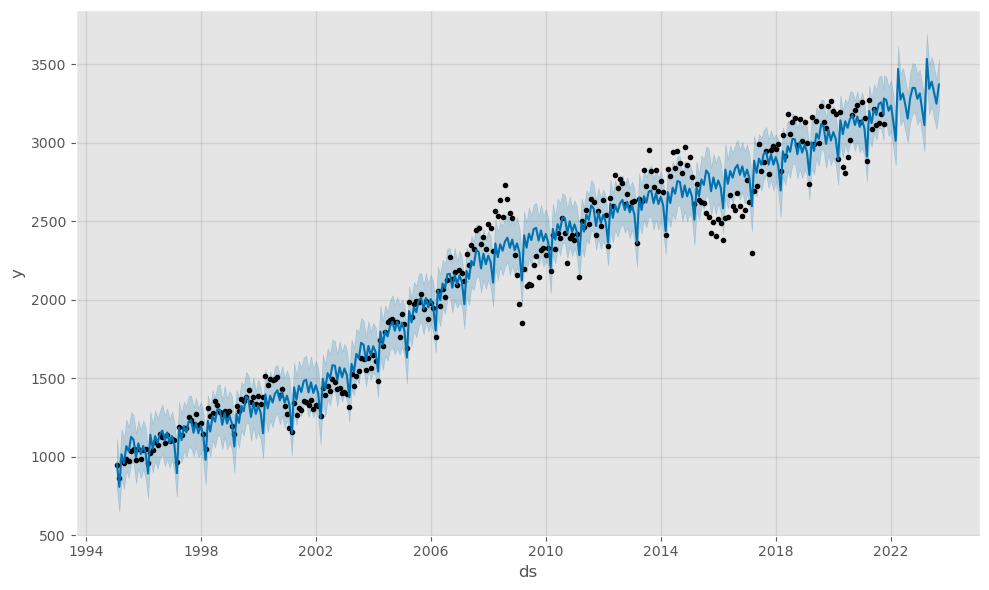

In [12]:
model.plot(forecast);

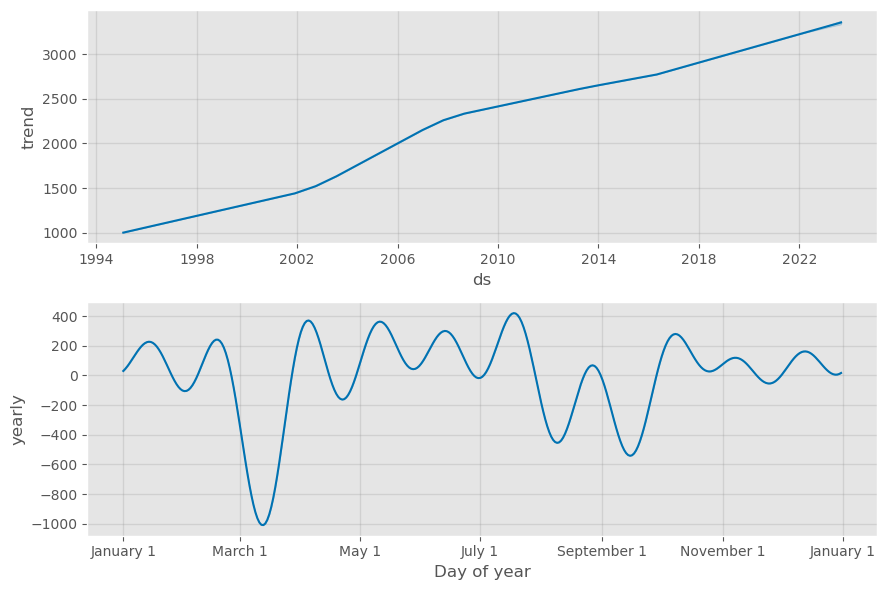

In [13]:
# decompose time series model into trend and seasonality
## The current value will be equivalent to sum of the corresponding values in the trend and yearly charts
model.plot_components(forecast);

## Model Evaluation
Evaluate model performance based on historical date range where both the predictions and actuals values are available

In [14]:
# add forecasted data to existing data set / data frame
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()

In [15]:
# optional - quick check on the future dates where the actual values are not available
metric_df.tail()

,ds,yhat,y
340,2023-04-30,3344.003995,NaN
341,2023-05-31,3390.029483,NaN
342,2023-06-30,3323.491117,NaN
343,2023-07-31,3249.387290,NaN
344,2023-08-31,3371.810128,NaN


In [16]:
# drop the rows of future dates where the actual values are not available
metric_df.dropna(inplace=True)

In [17]:
# optional - confirm if the rows of future dates have been dropped
metric_df.tail()

,ds,yhat,y
316,2021-05-28,3216.625756,3216.90425
317,2021-06-28,3177.696672,3114.50650
318,2021-07-28,3248.289157,3123.55950
319,2021-08-28,3258.203835,3182.28100
320,2021-09-28,3179.184998,3117.35950


In [18]:
rsquared = r2_score(metric_df.y, metric_df.yhat)
print('R-Squared: %.3f' % rsquared)

R-Squared: 0.969


In [19]:
mse= mean_squared_error(metric_df.y, metric_df.yhat)
print('MSE: %.3f' % mse)

MSE: 15271.303


In [20]:
rmse = mean_squared_error(metric_df.y, metric_df.yhat, squared=False)
print('RMSE: %.3f' % rmse)

RMSE: 123.577


In [21]:
mae = mean_absolute_error(metric_df.y, metric_df.yhat)
print('MAE: %.3f' % mae)

MAE: 95.857


In [22]:
mape = np.mean(np.abs((metric_df.y - metric_df.yhat)/metric_df.y))*100
print('MAPE: %.3f' % mape)

MAPE: 4.585
